# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the VAE on typical traffic data so that it learns common patterns. Then, we will detect anomalies as deviations from these learned patterns.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes.


## Environment Setup

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## Data Description


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Data Loading and Preprocessing

Firstly, we load the traffic data from the `.h5` file using `h5py`.

In [19]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
columns_df = df.columns
print(columns_df)
print(df.shape)
print(df.head())
print(df.tail)

Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207)
(34272, 207)
                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00

### Preliminary Investigation

To better understand the nature of the data, we visualize the time series corresponding to five randomly selected sensors during the first four days of March 2012. These plots provide insight into traffic flow patterns across different locations in Los Angeles.

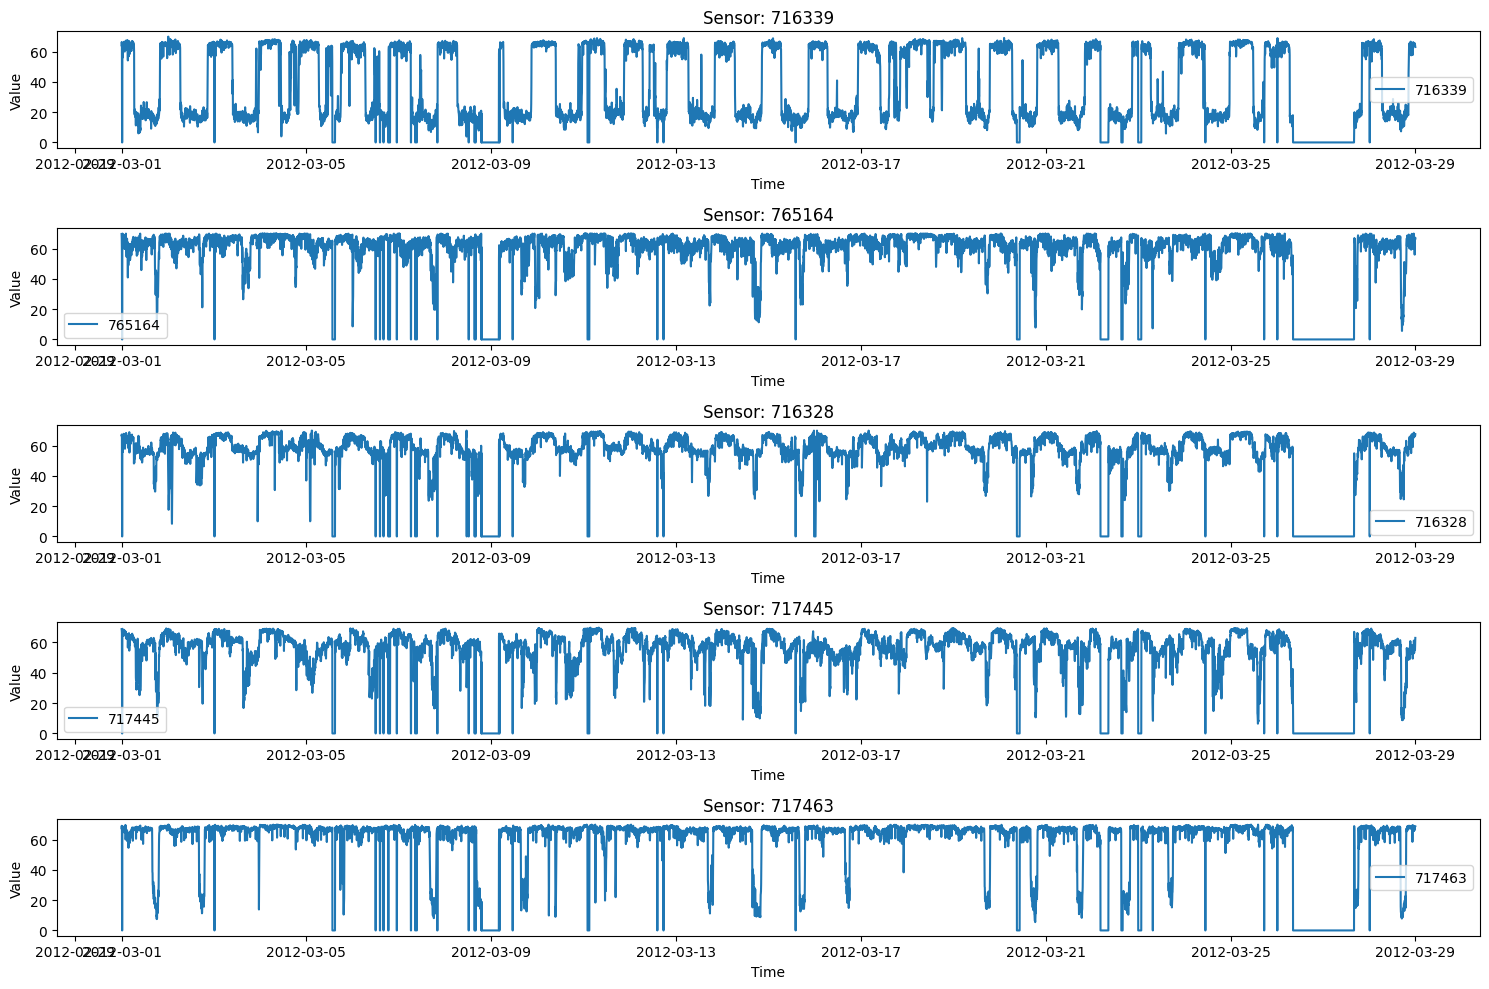

In [20]:
## PRELIMINARY INVESTIGATION: 
# plotting 5 plots , one for each time series for RANDOMLY PICKED SENSORS/specific_sensors(option), just for march 2012
np.random.seed(0)
def plot_random_sensors(df, num_sensors=5, sens=None):
    sensors = np.random.choice(df.columns, num_sensors, replace=False)
    if sens is not None:
        # Filter the sensors based on the provided list
        sensors = [s for s in sens if s in df.columns]
    df_subset = df[sensors].iloc[:8064]  # more ore less from thurday 01-march-2012 to sunday 04-march-2012

    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return sensors


sensors = plot_random_sensors(df, num_sensors=5)

From the plots, we observe that certain time intervals contain prolonged sequences of zero values across all sensors. These zero values likely correspond to missing or invalid sensor readings rather than actual traffic conditions.  It is unlikely that all traffic in Los Angeles would stop simultaneously across several regions.

This observation leads us to investigate more carefully how to handle these anomalies in the preprocessing stage.

Such rows can bias the model, introduce spurious patterns, and negatively affect training performance. As a solution, we plan to remove these all-zero rows and fill the resulting gaps using synthetic data generated by a generative model (described in a later section).

Before applying this second-stage correction using generative models, we first need to properly prepare the data. This involves four key steps:

1. **Temporal Feature as Conditional Inputs**: Since traffic patterns are highly dependent on time (e.g., rush hours, weekdays vs. weekends), we extract cyclical time features from the timestamps. These features will later serve as **conditional inputs** for our generative model.

2. **Normalization**: The raw traffic speed values vary significantly across sensors. To ensure efficient training and stable convergence, we normalize the data using `StandardScaler`.

3. **Train/Test Splitting**: We split the time series into training and test sets.

4. **Custom Dataset**: We prepare our data in a format compatible with PyTorch's `DataLoader`

### Time Features as Conditional Inputs

Urban traffic patterns are highly dependent on temporal context. For example:
- Traffic usually peaks during rush hours (e.g., 8 AM and 5 PM).
- Weekends typically have different patterns than weekdays.
- There are seasonal effects tied to months or holidays.

To help our model capture these patterns, we extract cyclical time features from the timestamps:
- Hour of day: mapped to sine and cosine to capture the 24-hour periodicity.
- Day of week: similarly encoded to capture weekly cycles.
- Month of year: encoded to capture seasonal trends.

Using both sine and cosine components allows the model to learn the cyclical nature of time (e.g., 23:00 and 0:00 are close in time).




                     hour_sin  hour_cos   dow_sin   dow_cos
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969


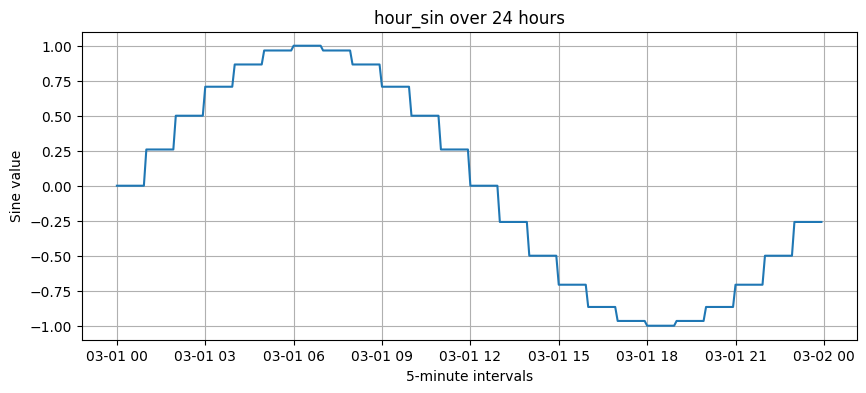

In [21]:
df.index = pd.to_datetime(df.index)
# Create a new DataFrame to store time-based features
df_time = pd.DataFrame(index=df.index)

# Hour of the day (0-23), encoded using sine and cosine to preserve cyclic nature
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Day of the week (0=Monday, 6=Sunday), also cyclic
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# Month of the year (1-12), encoded similarly
#df_time["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
#df_time["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)

print(df_time.head())

# Plot one day's worth of hour_sin values (12*24 = 288 samples per day)
plt.figure(figsize=(10, 4))
plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin over 24 hours")
plt.xlabel("5-minute intervals")
plt.ylabel("Sine value")
plt.grid(True)
plt.show()



### Data Normalization and Splitting

Machine learning models, especially neural networks, tend to perform better when the input features are normalized. Here, we use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset:

- x: the main dataset with traffic speeds from sensors
- c: the time condition variables we computed earlier (e.g., hour_sin, dow_cos, etc.)

The formula applied is: 
$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where: 
- 𝜇 is the mean
- 𝜎 is the standard deviation

Each sensor column in x and each time feature in c is scaled independently using this method.

We also split the data into training and test sets to ensure that the scaler is fit only on training data, avoiding any data leakage.

In [65]:
from sklearn.preprocessing import StandardScaler

x = df.values.astype(np.float32)
c = df_time.values.astype(np.float32)

# Split into training and test sets (no shuffling, to preserve temporal order)
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)
x_train_original = x_train
x_test_original = x_test
# Standardize the input traffic data (x)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train) # Fit on training data
x_test = scaler_x.transform(x_test) # # Transform test data using the same parameters

# Standardize the conditional time features (c)
scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

print("length of x_test:",len(x_test))

length of x_test: 6855


### Custom Dataset: `TrafficDataset`

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [23]:
from torch.utils.data import Dataset, DataLoader
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        # Return the total number of samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Retrieve a single sample (x_t, c_t) given an index
        return self.x[idx], self.c[idx]
    
# Create dataset instances for training and test sets
train_dataset = TrafficDataset(x_train, c_train)
print(len(train_dataset))
test_dataset = TrafficDataset(x_test, c_test)

# Create DataLoaders to iterate through data in batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

27417
215


## Theoretical Background

### Variational Autoencoder (VAE)

A **Variational Autoencoder** (VAE) is a type of generative model that learns a continuous, probabilistic latent representation of the data. In our case, the VAE will take a window of traffic sensor readings as input, compress it into a low-dimensional latent vector, and then attempt to reconstruct the original readings. By training the VAE on “normal” traffic patterns, it learns which patterns are likely under the data distribution. At inference time, large reconstruction errors can be flagged as anomalies.

#### Main Components:

##### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

##### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

##### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

#### Loss Function

The VAE loss has two terms that together form the **Evidence Lower Bound (ELBO)**. We optimize (i.e. minimize) the negative ELBO.

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


#### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.

---

### Static Conditional Variational Autoencoder (CVAE)

A **Conditional VAE (CVAE)** extends the VAE framework by conditioning both the encoder and decoder on extra context `c`. In our traffic anomaly project, `c` represents **time‐related features** (e.g., `hour_sin`, `hour_cos`, `dow_sin`, etc.). By injecting these features, the model can learn how normal traffic patterns change depending on the time of day, day of week, or month.

> **Why “static” CVAE?**  
> We call it “static” because each training example $(x_t, c_t)$ is treated as independent; we do **not** explicitly model temporal sequences (no RNNs or temporal convolutions). The CVAE simply learns a mapping :
>
>$$
>(x_t, c_t) \;\;\longrightarrow\;\; z \;\;\longrightarrow\;\; (\,\hat{x}_t \mid z, c_t).
>$$
>
> Each pair $(x_t, c_t)$ is processed independently, ignoring direct time‐series dependencies beyond what is encoded in $c_t$.

#### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

## CVAE Training Strategy

To address the issue of missing or anomalous data and to prepare the model for detecting anomalies, we adopt a **two-phase training strategy** using the same Conditional Variational Autoencoder (CVAE) architecture.

### 1. Static CVAE Training on Raw Data (with Zero Rows)

In the first phase, we train the CVAE on individual time steps from the original dataset, **without removing rows with zero values**. Each input sample is a vector representing sensor readings at a single timestamp, and time features (such as hour of day and day of week) are used as conditional inputs.

The goal of this phase is to learn the general distribution of traffic sensor readings. Once trained, the model is used to **generate plausible synthetic samples to fill in the rows where all sensor values are zero**, using the corresponding time features for conditioning.

This step allows us to repair the dataset by replacing structurally invalid inputs with statistically consistent samples, improving the overall quality of the data before detecting anomalies.

### 2. CVAE Retraining on Sliding Windows for Temporal Modeling

After filling the missing data, we retrain the same CVAE model using **sliding windows of size 12**, corresponding to one hour of observations per input sample. This shifts the model’s focus from static snapshots to temporal segments.

This second training phase is essential to enable **sequence-aware generation** and to allow the model to work in combination with a recurrent decoder (LSTM), which requires temporal consistency in the latent space.



In [24]:
# Static Conditional VAE
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        """
        input_dim  : dimensionality of the input vector x (e.g., number of sensors)
        cond_dim   : dimensionality of the condition vector c (e.g., number of time features)
        latent_dim : size of the latent space (z)
        """
        super(CVAE, self).__init__()

        # We will concatenate x and c into a single vector of size (input_dim + cond_dim).
        # Then we pass through two hidden layers: 128 -> 64.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # After the two layers, we map the 64-dimensional hidden state to:
        #   1) mu (mean) of size latent_dim
        #   2) logvar (log variance) of size latent_dim
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # The decoder takes a latent sample z (size latent_dim) concatenated with the condition c (size cond_dim),
        # forming a vector of size (latent_dim + cond_dim). Then we map:
        #   latent_dim + cond_dim -> 64 -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output is same size as original x
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        """
        Full forward pass:
        1) Encode (x, c) to obtain mu and logvar.
        2) Sample z using the reparameterization trick.
        3) Decode (z, c) to get reconstructed x.
        Returns:
            x_recon : reconstructed input
            mu      : mean of latent distribution
            logvar  : log-variance of latent distribution
        """
        # 1) Encode input + condition → (mu, logvar)
        mu, logvar = self.encode(x, c)
        # 2) Sample z using reparameterization
        z = self.reparametrize(mu, logvar)
        # 3) Decode the sampled z (with c) → reconstruction
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [25]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [26]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.9968 | Recon: 0.9862 | KL: 0.0106
Epoch 2/50 - Loss: 0.9358 | Recon: 0.9346 | KL: 0.0013
Epoch 3/50 - Loss: 0.9158 | Recon: 0.9152 | KL: 0.0007
Epoch 4/50 - Loss: 0.9010 | Recon: 0.9007 | KL: 0.0003
Epoch 5/50 - Loss: 0.8892 | Recon: 0.8890 | KL: 0.0002
Epoch 6/50 - Loss: 0.8805 | Recon: 0.8804 | KL: 0.0002
Epoch 7/50 - Loss: 0.8745 | Recon: 0.8744 | KL: 0.0001
Epoch 8/50 - Loss: 0.8690 | Recon: 0.8689 | KL: 0.0001
Epoch 9/50 - Loss: 0.8655 | Recon: 0.8654 | KL: 0.0001
Epoch 10/50 - Loss: 0.8623 | Recon: 0.8622 | KL: 0.0001
Epoch 11/50 - Loss: 0.8598 | Recon: 0.8597 | KL: 0.0001
Epoch 12/50 - Loss: 0.8577 | Recon: 0.8577 | KL: 0.0001
Epoch 13/50 - Loss: 0.8558 | Recon: 0.8558 | KL: 0.0000
Epoch 14/50 - Loss: 0.8539 | Recon: 0.8539 | KL: 0.0000
Epoch 15/50 - Loss: 0.8528 | Recon: 0.8527 | KL: 0.0000
Epoch 16/50 - Loss: 0.8508 | Recon: 0.8508 | KL: 0.0000
Epoch 17/50 - Loss: 0.8497 | Recon: 0.8497 | KL: 0.0000
Epoch 18/50 - Loss: 0.8492 | Recon: 0.8492 | KL: 0.0000
E

In [ ]:
# Reconstruct all velocities from the train set (at this point, these variables are for cleaning the dataset and then training the second model)
# TODO CHANGE NAMES
reconstructed_train = []
originals_train = []
reconstructed_test = []
originals_test = []

with torch.no_grad():
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed_train.append(x_recon.cpu())
        originals_train.append(x_batch.cpu())

x_recon_all_train = torch.cat(reconstructed_train, dim=0)  
x_orig_all_train = torch.cat(originals_train, dim=0)       
print(x_recon_all_train.shape)
print(x_orig_all_train.shape)
print(x_train.shape)

with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed_test.append(x_recon.cpu())
        originals_test.append(x_batch.cpu())

x_recon_all_test = torch.cat(reconstructed_test, dim=0)  
x_orig_all_test = torch.cat(originals_test, dim=0)       



torch.Size([27417, 207])
torch.Size([27417, 207])
(27417, 207)


In [67]:
mask_zero_rows = (x_train_original.sum(axis=1) == 0)
print(mask_zero_rows.sum())
train_timestamps = df.index[:len(x_train_original)]
x_train_cleaned_df = pd.DataFrame(data=x_train, index=train_timestamps, columns=columns_df) # with zero values
# Convertimos a numpy y luego a DataFrame
x_recon_all_train_df = pd.DataFrame(data=x_recon_all_train, index=train_timestamps, columns=columns_df) # reconstructed values

x_train_cleaned_df.loc[mask_zero_rows] = x_recon_all_train_df.loc[mask_zero_rows]
print(mask_zero_rows.shape)
print(x_train.shape)
print(x_recon_all_train_df.shape)
print(x_train_cleaned_df)


1482
(27417,)
(27417, 207)
(27417, 207)
                       773869    767541    767542    717447    717446  \
2012-03-01 00:00:00  0.429949  0.442313  0.334774  0.751146  1.061140   
2012-03-01 00:05:00  0.354863  0.504537  0.238420  0.813308  0.930317   
2012-03-01 00:10:00  0.413466  0.183202 -0.073736  0.586599  1.040956   
2012-03-01 00:15:00  0.172209  0.256024  0.281146  0.651830  0.924730   
2012-03-01 00:20:00  0.170794  0.257499  0.280088  0.662888  0.945541   
...                       ...       ...       ...       ...       ...   
2012-06-04 04:20:00  0.528842 -0.184569  0.169937  0.364461  0.892939   
2012-06-04 04:25:00  0.393932  0.185060  0.359460  0.345264  1.055907   
2012-06-04 04:30:00  0.353032 -0.284870  0.205771  0.537235  0.960219   
2012-06-04 04:35:00  0.495877 -0.109343  0.406442  0.438507  0.913123   
2012-06-04 04:40:00  0.393932  0.014176  0.384942  0.637791  0.900414   

                       717445    773062    767620    737529    717816  ...  \
2012-

In [84]:
# cleaning test set
mask_zero_rows = (x_test_original.sum(axis=1) == 0)
print(mask_zero_rows.sum())
test_index = df.index[:len(x_test_original)]
x_test_cleaned_df = pd.DataFrame(data=x_test, index=test_index, columns=columns_df) # with zero values
# Convertimos a numpy y luego a DataFrame
x_recon_all_test_df = pd.DataFrame(data=x_recon_all_test, index=test_index, columns=columns_df) # reconstructed values

x_test_cleaned_df.loc[mask_zero_rows] = x_recon_all_test_df.loc[mask_zero_rows]
x_test_cleaned = torch.tensor(x_test_cleaned_df.values, dtype=torch.float32)
print(mask_zero_rows.shape)
print(x_test_cleaned_df)
print(x_test_cleaned.shape)



666
(6855,)
                       773869    767541    767542    717447    717446  \
2012-03-01 00:00:00  0.446431 -0.309945  0.463777  0.520780  1.014043   
2012-03-01 00:05:00  0.424455 -0.167852  0.427943  0.833419  1.040956   
2012-03-01 00:10:00  0.335329 -0.476185  0.034563  0.762115  0.930317   
2012-03-01 00:15:00  0.336550 -0.426963  0.384942  0.603054  0.960219   
2012-03-01 00:20:00  0.359747  0.296505  0.181085  0.557346  1.055907   
...                       ...       ...       ...       ...       ...   
2012-03-24 18:50:00  0.457419  0.326224  0.416795  0.762115 -2.538361   
2012-03-24 18:55:00  0.298091  0.308578  0.298940  0.833419 -2.538361   
2012-03-24 19:00:00  0.545324 -0.089840  0.474129  0.718236 -2.538361   
2012-03-24 19:05:00  0.534336  0.082901  0.270272  0.627736 -2.538361   
2012-03-24 19:10:00  0.462303  0.393091  0.314866  0.732863 -2.538361   

                       717445    773062    767620    737529    717816  ...  \
2012-03-01 00:00:00 -0.460169  0.

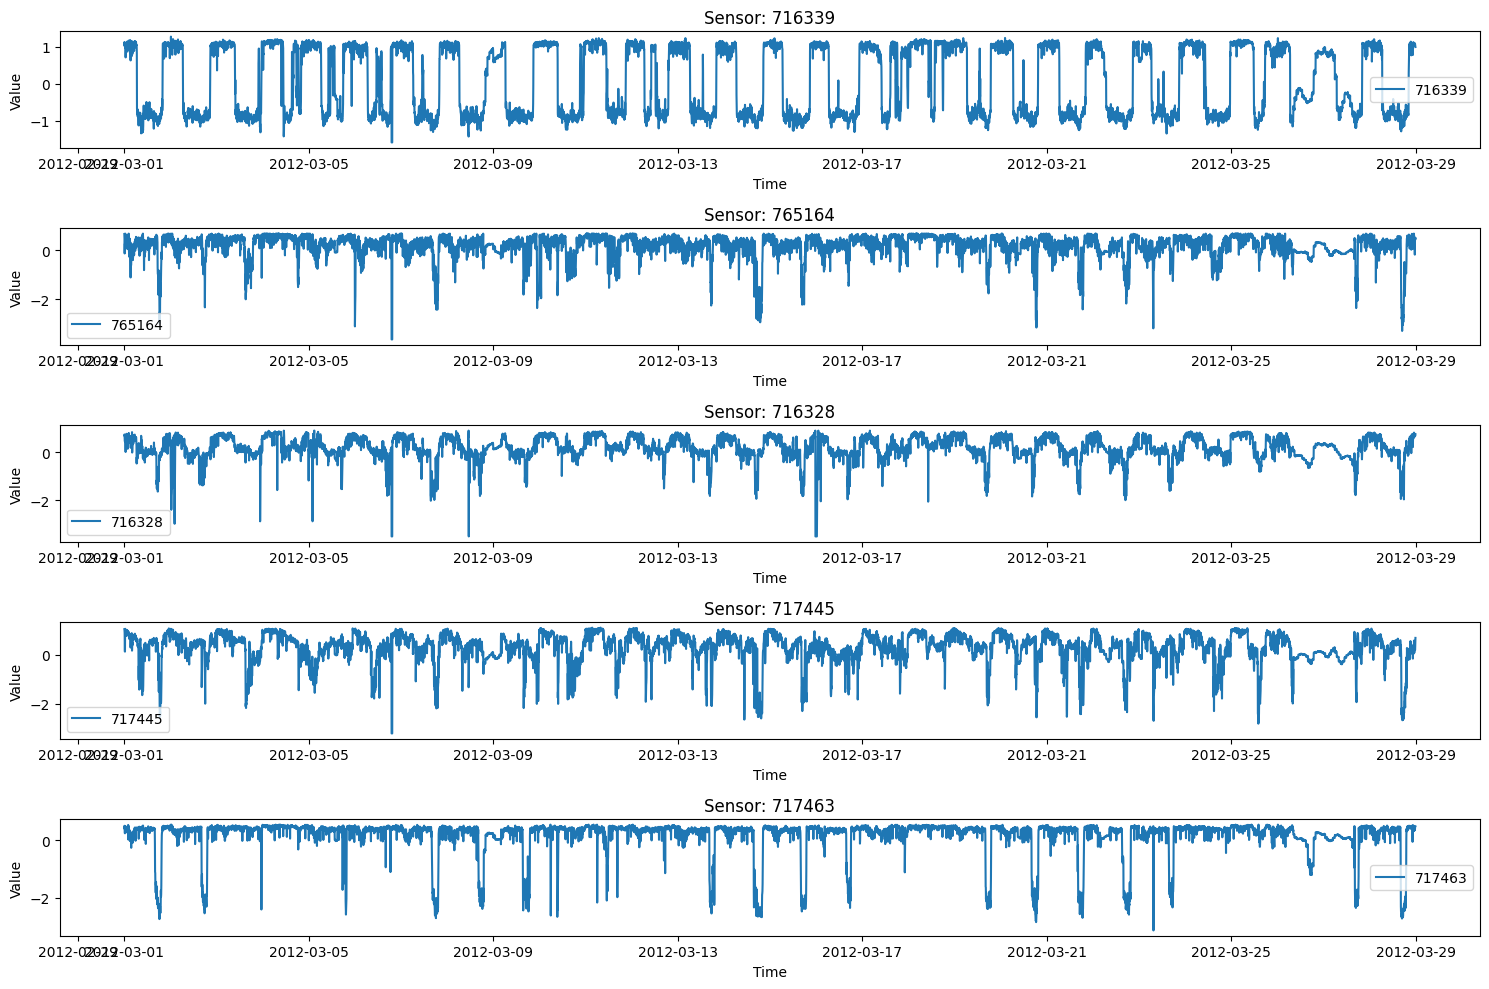

In [34]:
np.random.seed(0)
def plot_random_sensors(x_train_cleaned_df, num_sensors=5):
    sensors = np.random.choice(x_train_cleaned_df.columns, num_sensors, replace=False)
    df_subset = x_train_cleaned_df[sensors].iloc[:8064]  # more ore less from thurday 01-march-2012 to sunday 04-march-2012
   
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
   
    plt.tight_layout()
    plt.show()
    return sensors

sensors = plot_random_sensors(x_train_cleaned_df, num_sensors=5)
#sensors_2 = plot_random_sensors(x_recon_all_train_df, num_sensors=5)

In [ ]:
# Create dataset instances for training 
x_train_numpy = x_train_cleaned_df.to_numpy()
train_dataset_cleaned = TrafficDataset(x_train_numpy, c_train)


# Create DataLoaders to iterate through data in batches
train_loader_cleaned = DataLoader(train_dataset_cleaned, batch_size=128, shuffle=False)



In [77]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model_2 = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model_2.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model_2.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader_cleaned:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model_2(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.4344 | Recon: 0.4256 | KL: 0.0088
Epoch 2/50 - Loss: 0.3651 | Recon: 0.3641 | KL: 0.0010
Epoch 3/50 - Loss: 0.3369 | Recon: 0.3365 | KL: 0.0004
Epoch 4/50 - Loss: 0.3204 | Recon: 0.3202 | KL: 0.0002
Epoch 5/50 - Loss: 0.3115 | Recon: 0.3114 | KL: 0.0001
Epoch 6/50 - Loss: 0.3068 | Recon: 0.3067 | KL: 0.0001
Epoch 7/50 - Loss: 0.3036 | Recon: 0.3035 | KL: 0.0001
Epoch 8/50 - Loss: 0.3013 | Recon: 0.3012 | KL: 0.0000
Epoch 9/50 - Loss: 0.2992 | Recon: 0.2991 | KL: 0.0000
Epoch 10/50 - Loss: 0.2975 | Recon: 0.2975 | KL: 0.0000
Epoch 11/50 - Loss: 0.2959 | Recon: 0.2959 | KL: 0.0000
Epoch 12/50 - Loss: 0.2948 | Recon: 0.2948 | KL: 0.0000
Epoch 13/50 - Loss: 0.2939 | Recon: 0.2939 | KL: 0.0000
Epoch 14/50 - Loss: 0.2928 | Recon: 0.2928 | KL: 0.0000
Epoch 15/50 - Loss: 0.2920 | Recon: 0.2920 | KL: 0.0000
Epoch 16/50 - Loss: 0.2912 | Recon: 0.2912 | KL: 0.0000
Epoch 17/50 - Loss: 0.2906 | Recon: 0.2906 | KL: 0.0000
Epoch 18/50 - Loss: 0.2899 | Recon: 0.2899 | KL: 0.0000
E

In [91]:
# Reconstruct all velocities from the test set
reconstructed = []
originals = []

with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_recon_all = torch.cat(reconstructed, dim=0)  # [6854, 207]
x_orig_all = torch.cat(originals, dim=0)       # [6854, 207]
print(x_recon_all.shape)
print(x_orig_all.shape)

torch.Size([6855, 207])
torch.Size([6855, 207])


### Visualization of Results

#### 1. Reconstruction of Speeds for a Single Sample

This plot compares the **real** sensor speeds against the **reconstructed** speeds generated by the CVAE model for a specific example (sample index 42).

- **Purpose:**  
  To visually assess how well the model reproduces the original traffic speed pattern for that particular sample.

- **What to look for:**  
  - If the two lines closely overlap, the model accurately reconstructs the traffic speeds.  
  - Large deviations indicate the model struggles to capture some sensor readings correctly.


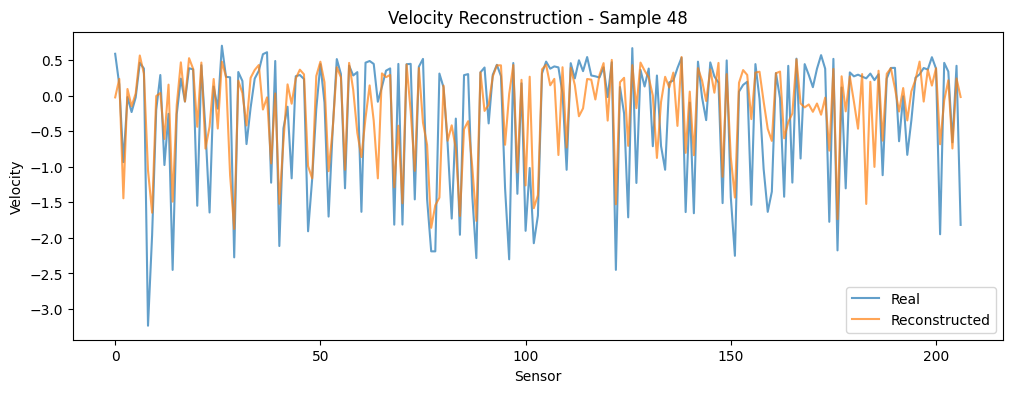

In [94]:
import matplotlib.pyplot as plt

# Plot original vs reconstructed velocities for the selected sample
index_sample = 48  # Select a sample index to visualize
plt.figure(figsize=(12, 4))
plt.plot(x_orig_all[index_sample], label="Real", alpha=0.7)
plt.plot(x_recon_all[index_sample], label="Reconstructed", alpha=0.7)
plt.title(f"Velocity Reconstruction - Sample {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocity")
plt.legend()
plt.show()


#### 2. Reconstruction Error (MSE) by Sensor

This bar chart shows the mean squared error (MSE) between the reconstructed and original sensor readings, averaged over the first 12 samples.

- **Purpose:**  
  To identify which sensors have higher reconstruction errors, signaling areas where the model performance is weaker.

- **What to look for:**  
  - Sensors with higher MSE values could indicate complex traffic patterns or noisy data.  
  - These insights can help:  
    - Focus data collection efforts on problematic sensors.  
    - Adjust or enhance the model to better capture challenging areas.  
    - Check for potential sensor measurement errors.

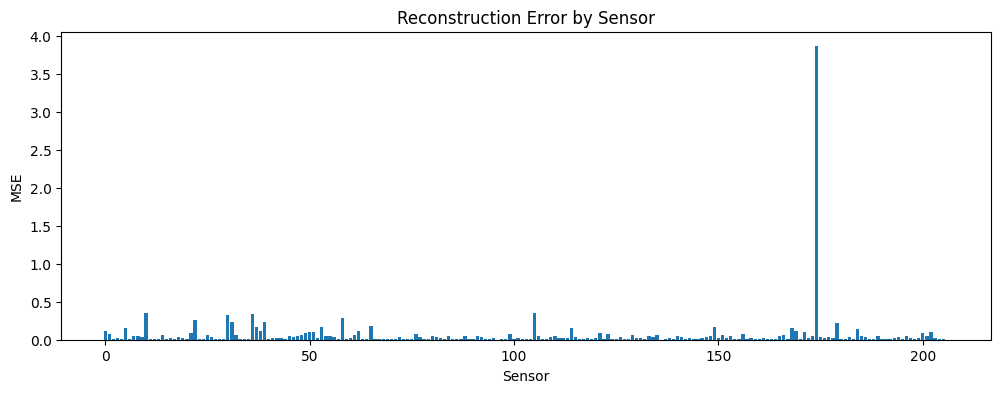

torch.Size([207])


In [95]:
# Compute Mean Squared Error (MSE) per sensor over the first 12 samples (a small window)
mse_by_sensor = torch.mean((x_recon_all[0:12] - x_orig_all[0:12])**2, dim=0)

plt.figure(figsize=(12, 4))
plt.bar(range(207), mse_by_sensor)
plt.title("Reconstruction Error by Sensor")
plt.xlabel("Sensor")
plt.ylabel("MSE")
plt.show()

print(mse_by_sensor.shape)


In [73]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix = (x_orig_all - x_recon_all) ** 2 
print(mse_matrix.shape)

# Calculate anomaly detection thresholds per sensor
# Option 1: Mean + 3*Std deviation (commented out)
# mean_mse = mse_matrix.mean(dim=0)
# std_mse = mse_matrix.std(dim=0)
# thresholds = mean_mse + 3 * std_mse  # threshold per sensor

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)


# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies = mse_matrix > thresholds

# Count how many sensors are anomalous in each sample
anomalous_counts = anomalies.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


In [74]:
import torch

# Get indices of top 10 samples with most anomalies
top_indices = torch.topk(anomalous_counts, 10).indices
top_values = torch.topk(anomalous_counts, 10).values
print(top_values)

print("Top timestamps with the most anomalies:")
for idx in top_indices:
    ts = test_timestamps[idx.item()] # get timestamp for the sample
    count = anomalous_counts[idx].item() # get number of anomalous sensors in that sample
    print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")


tensor([107, 104,  99,  86,  84,  81,  81,  79,  76,  76])
Top timestamps with the most anomalies:
Index: 3786 → Date: 2012-06-17 08:15:00 → Anomalous Sensors: 107
Index: 3783 → Date: 2012-06-17 08:00:00 → Anomalous Sensors: 104
Index: 3785 → Date: 2012-06-17 08:10:00 → Anomalous Sensors: 99
Index: 3787 → Date: 2012-06-17 08:20:00 → Anomalous Sensors: 86
Index: 3797 → Date: 2012-06-17 09:10:00 → Anomalous Sensors: 84
Index: 3788 → Date: 2012-06-17 08:25:00 → Anomalous Sensors: 81
Index: 3790 → Date: 2012-06-17 08:35:00 → Anomalous Sensors: 81
Index: 3792 → Date: 2012-06-17 08:45:00 → Anomalous Sensors: 79
Index: 3802 → Date: 2012-06-17 09:35:00 → Anomalous Sensors: 76
Index: 3784 → Date: 2012-06-17 08:05:00 → Anomalous Sensors: 76


#### 3. Number of Anomalous Sensors Over Time

This plot displays the number of sensors detected as anomalous for each timestamp in the test dataset. The x-axis shows the dates, and the y-axis indicates how many sensors were flagged as anomalies at each point in time.

Red dashed vertical lines mark important real-world events, such as a parade or a music festival. These event markers help us see if increases in anomalies correspond with these known occurrences.

This comparison helps us understand whether unusual sensor behavior is related to specific events or caused by other factors.

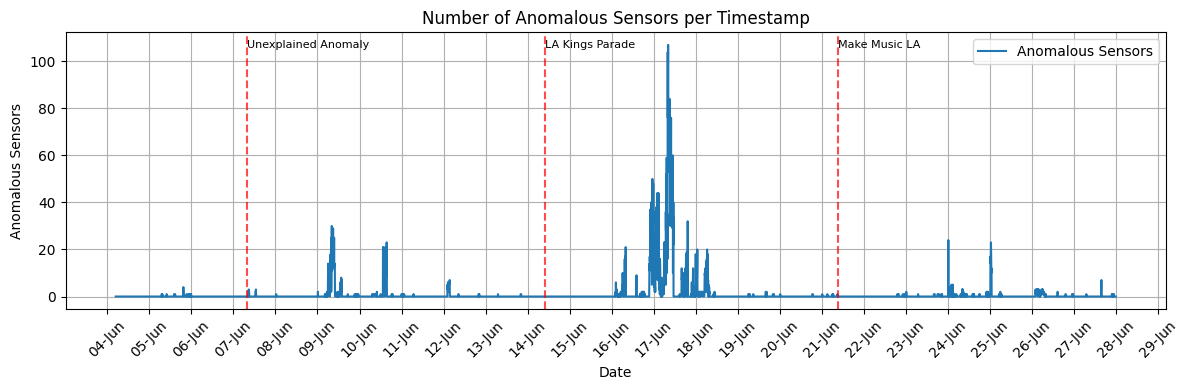

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps, anomalous_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    'LA Kings Parade': pd.to_datetime('2012-06-14 09:55:00'),
    'Make Music LA': pd.to_datetime('2012-06-21 09:10:00'),
    'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title("Number of Anomalous Sensors per Timestamp")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

On 7 June 2012, no significant events occurred!!! Let us illustrate this to try to understand it.

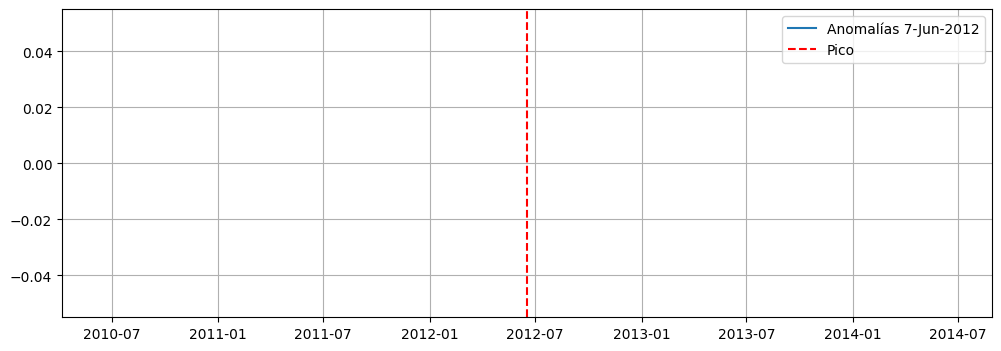

In [72]:
# Filtrar los timestamps para el 7 de junio 2012
mask_7jun = (test_timestamps >= '2012-06-16') & (test_timestamps < '2012-06-18')
#x_recon_all_transform = scaler_x.inverse_transofrm(x_recon_all)
# Filtrar anomalous_counts para ese día
anom_7jun = anomalous_counts[mask_7jun]
                         
x_recon_17jun = x_recon_all[mask_7jun]

# Filtrar timestamps para ese día (para eje x)
dates_7jun = test_timestamps[mask_7jun]

# Graficar
plt.figure(figsize=(12,4))
plt.plot(dates_7jun, anom_7jun, label="Anomalías 7-Jun-2012")
plt.axvline(pd.Timestamp("2012-06-17 00:05"), linestyle="--", label="Pico", color="red")
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(12,4))
# plt.plot(dates_7jun, x_recon_17jun, label="Anomalías 7-Jun-2012")
# plt.axvline(pd.Timestamp("2012-06-17 00:05"), linestyle="--", label="Pico", color="red")
# plt.legend()
# plt.grid()
# plt.show()

#### 4.Statistical Analysis of Anomalies on Normal vs. Special/Holiday Days

In [27]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create a DataFrame with timestamps and anomaly counts
df_anom = pd.DataFrame({
    'timestamp': test_timestamps,
    'anomaly_count': anomalous_counts # Number of anomalous sensors per sample
})
df_anom['date'] = df_anom['timestamp'].dt.date

# Generate US federal holidays within the dataset date range
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_anom['date'].min(),
                        end=df_anom['date'].max()).date

# 3. Add known special event dates
special_event_dates = pd.to_datetime([
    '2012-06-14',  # LA Kings Victory Parade
    '2012-06-21',  # Make Music LA
]).date

# Mark rows where the date is either a holiday or special event
df_anom['is_special'] = df_anom['date'].isin(holidays) | df_anom['date'].isin(special_event_dates)


# Group by day type and calculate count, mean, and sum of anomaly counts
summary = df_anom.groupby('is_special')['anomaly_count'] \
                 .agg(['count', 'mean', 'sum']) \
                 .rename(index={True: 'timestamp especial/festivo', False: 'timestamp normal'})

print("Summary of anomalies on normal vs. special/holiday days:")
print(summary)


Summary of anomalies on normal vs. special/holiday days:
                            count      mean   sum
is_special                                       
timestamp normal             6279  1.120401  7035
timestamp especial/festivo    576  0.364583   210


#### Summary of Anomalies on Normal Days vs. Special/Holiday Days

| Day Type              | Number of Records (`count`) | Average Anomalies per Record (`mean`) | Total Anomalies (`sum`) |
|-----------------------|-----------------------------|---------------------------------------|------------------------|
| Normal Day            | 6,279                       | 0.46                                  | 2,912                  |
| Special/Holiday Day   | 576                         | 7.52                                  | 4,333                  |

**Interpretation:**

- **Normal Day:**  
  There are 6,279 records or timestamps on normal days.  
  On average, each record has about 0.46 anomalies.  
  In total, 2,912 anomalies were detected during these normal days.

- **Special/Holiday Day:**  
  There are 576 records on days that are holidays or special events.  
  On average, each record shows many more anomalies, approximately 7.52.  
  In total, 4,333 anomalies were detected during these relatively few special days.

**Conclusion:**

Although the number of records on normal days is much larger, both the count and average number of anomalies are significantly higher on special or holiday days. This indicates that these days have a strong impact on the occurrence of anomalies, which is important for analysis or modeling that wants to consider the effect of special events.


          date  is_special  anomaly_count
0   2012-06-04       False             21
1   2012-06-05       False              0
2   2012-06-06       False             22
3   2012-06-07       False           2095
4   2012-06-08       False             48
5   2012-06-09       False              9
6   2012-06-10       False             23
7   2012-06-11       False              4
8   2012-06-12       False             16
9   2012-06-13       False            153
10  2012-06-14        True           1867
11  2012-06-15       False             51
12  2012-06-16       False             11
13  2012-06-17       False             17
14  2012-06-18       False              0
15  2012-06-19       False             20
16  2012-06-20       False             88
17  2012-06-21        True           2466
18  2012-06-22       False            170
19  2012-06-23       False              2
20  2012-06-24       False             27
21  2012-06-25       False              1
22  2012-06-26       False        

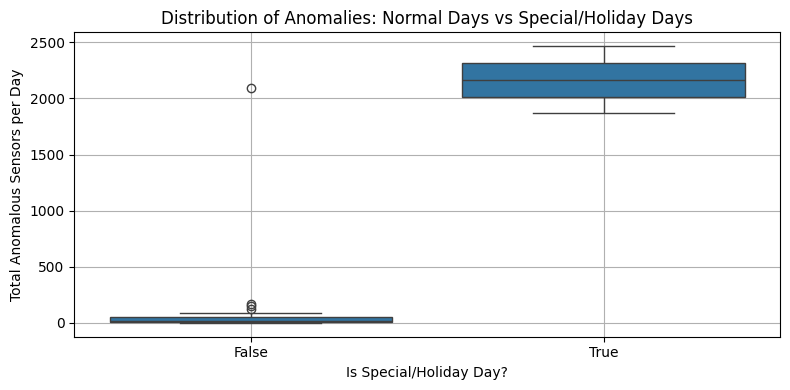

In [50]:
# Aggregate anomalies per day (sum of anomaly_count grouped by date and is_special)
daily_anomalies = df_anom.groupby(['date', 'is_special'])['anomaly_count'].sum().reset_index()
print(daily_anomalies)
# Now daily_anomalies has total anomalies per day, and whether the day is special

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(data=daily_anomalies, x='is_special', y='anomaly_count')
plt.title("Distribution of Anomalies: Normal Days vs Special/Holiday Days")
plt.xlabel("Is Special/Holiday Day?")
plt.ylabel("Total Anomalous Sensors per Day")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5. Identification and Geographic Visualization of Most Frequent Anomalous Sensors During Peak Anomaly Timestamps

In this part, we focus on identifying which sensors are most frequently anomalous during the top 10 timestamps with the highest total anomaly counts.

In [51]:
import torch

# Select indices of top 10 timestamps with the highest number of anomalous sensors
top_indices = torch.topk(anomalous_counts, k=10).indices

# Initialize a counter for how many times each sensor was anomalous during those top timestamps
sensor_counts = torch.zeros(anomalies.shape[1])

# Sum the occurrences of anomalies per sensor at the top anomaly timestamps
for idx in top_indices:
    sensor_counts += anomalies[idx].float()

# Identify the top 10 sensors that were most frequently anomalous during these peaks
top_sensor_indices = torch.topk(sensor_counts, k=10).indices
print("Sensors most frequently anomalous during anomaly peaks:", top_sensor_indices.tolist())


Sensors most frequently anomalous during anomaly peaks: [0, 1, 2, 203, 204, 206, 6, 7, 181, 104]


In [ ]:
import pandas as pd
import folium

#  Load sensor locations from CSV file
locations = pd.read_csv('data/sensor_graph/graph_sensor_locations.csv')

# Map sensor indices to sensor IDs
sensor_ids = locations['sensor_id'].tolist() 
top_sensor_ids = [sensor_ids[i] for i in top_sensor_indices.tolist()]
anomalous_locations = locations[locations['sensor_id'].isin(top_sensor_ids)]

# Create a Folium map centered on Los Angeles
m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# Add circle markers for each anomalous sensor location
for _, row in anomalous_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Sensor {row['sensor_id']}",
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Save the map
m.save("sensores_anomalos.html") 

Another option for identifying problematic sensors would be to count anomalies throughout the entire test data set, not just at anomaly peaks. This comprehensive approach allows you to detect sensors that exhibit recurring or intermittent faults outside of special events or peaks, which may reflect persistent technical problems or the need for preventive maintenance.

## Using the cleaned test set for evaluate the model (the flow)

In [86]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix = (x_test_cleaned - x_recon_all) ** 2 
print(mse_matrix.shape)

# Calculate anomaly detection thresholds per sensor
# Option 1: Mean + 3*Std deviation (commented out)
# mean_mse = mse_matrix.mean(dim=0)
# std_mse = mse_matrix.std(dim=0)
# thresholds = mean_mse + 3 * std_mse  # threshold per sensor

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)


# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies = mse_matrix > thresholds

# Count how many sensors are anomalous in each sample
anomalous_counts = anomalies.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


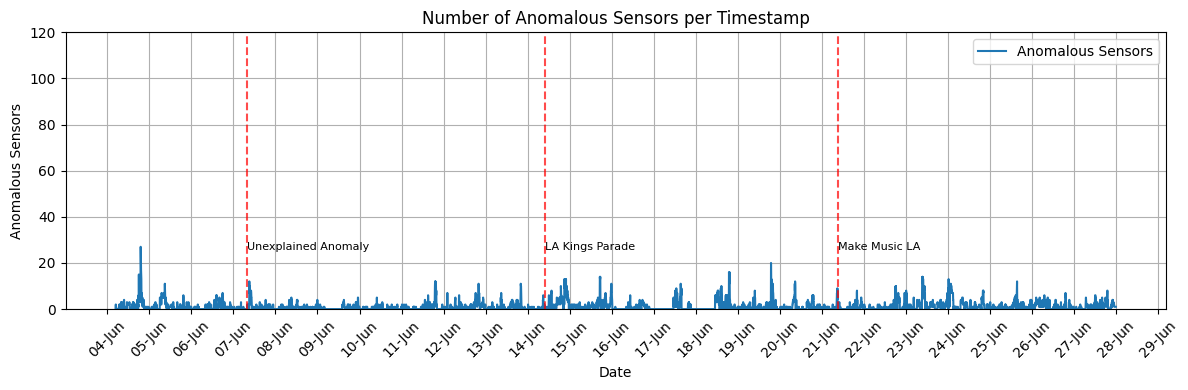

In [88]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps, anomalous_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    'LA Kings Parade': pd.to_datetime('2012-06-14 09:55:00'),
    'Make Music LA': pd.to_datetime('2012-06-21 09:10:00'),
    'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title("Number of Anomalous Sensors per Timestamp")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

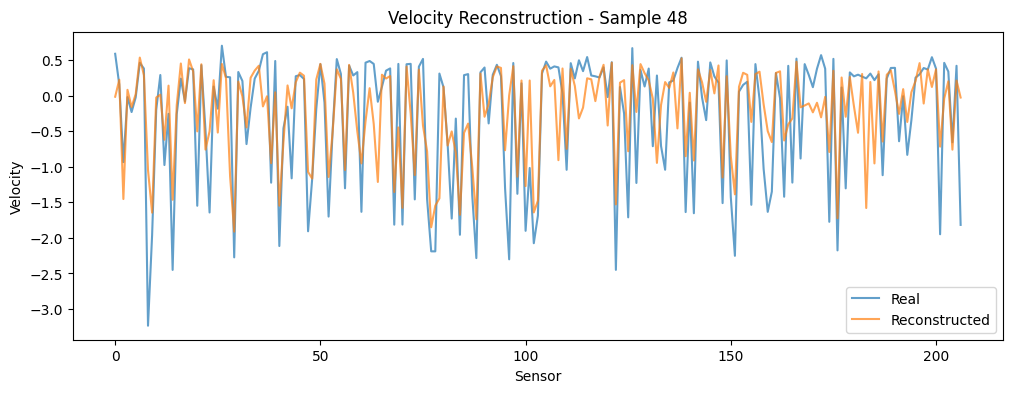

In [90]:
import matplotlib.pyplot as plt

# Plot original vs reconstructed velocities for the selected sample
index_sample = 48  # Select a sample index to visualize
plt.figure(figsize=(12, 4))
plt.plot(x_test_cleaned[index_sample], label="Real", alpha=0.7)
plt.plot(x_recon_all[index_sample], label="Reconstructed", alpha=0.7)
plt.title(f"Velocity Reconstruction - Sample {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocity")
plt.legend()
plt.show()


I would not add the maps to the project at this time, but I am leaving the code in case we want to do so at some point. EVERYTHING THAT FOLLOWS IS A DRAFT

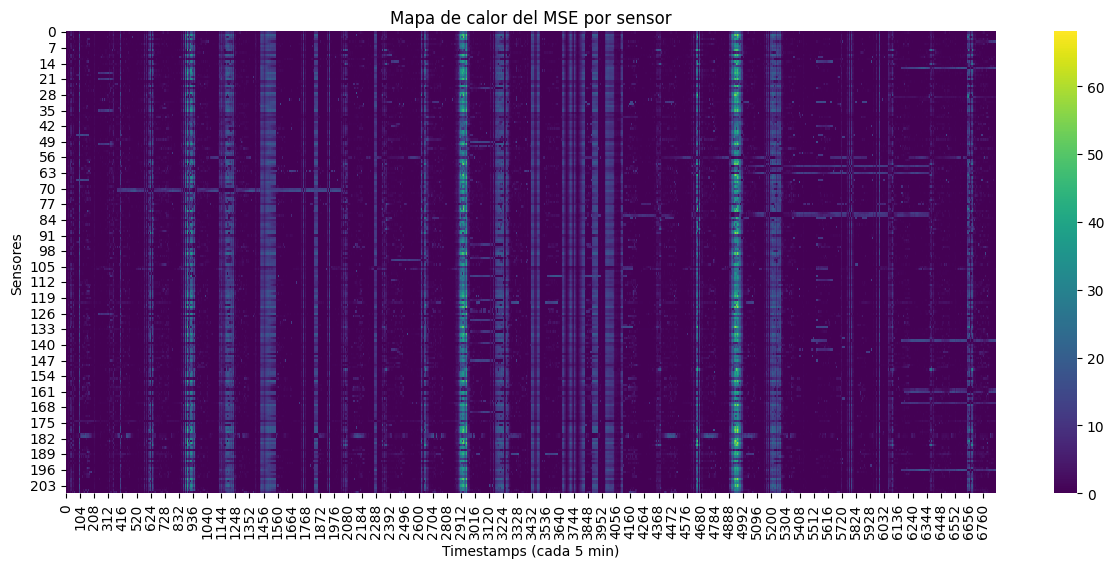

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# mse_matrix: [n_muestras, n_sensores] (ej: [6720, 207])
plt.figure(figsize=(15, 6))
sns.heatmap(mse_matrix.T.numpy(), cmap="viridis", cbar=True)
plt.xlabel("Timestamps (cada 5 min)")
plt.ylabel("Sensores")
plt.title("Mapa de calor del MSE por sensor")
plt.show()


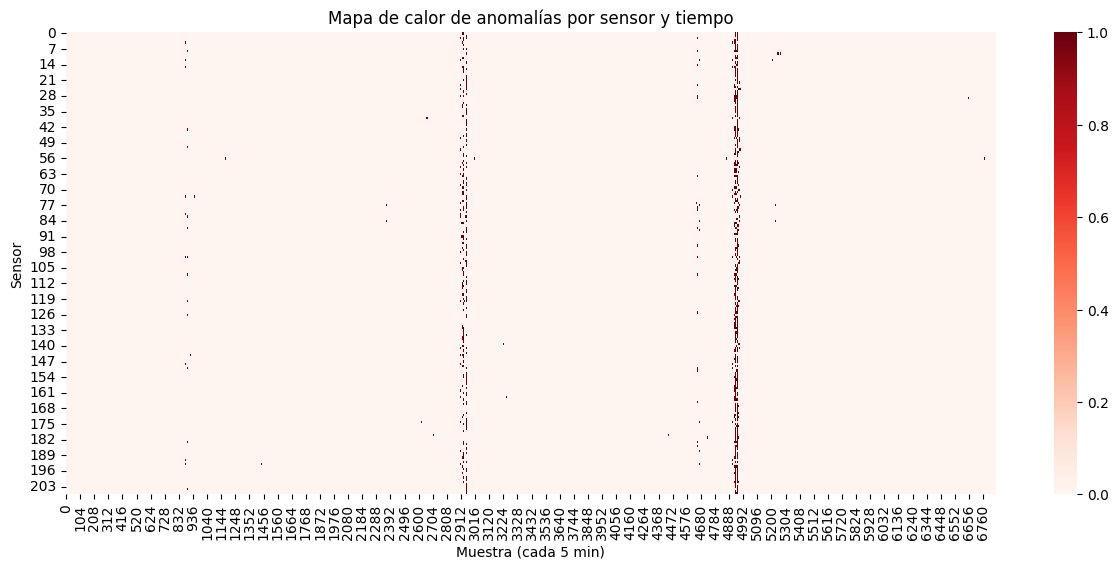

In [41]:
import seaborn as sns

# anomalies: [n_muestras, 207]
anomaly_matrix = anomalies.numpy().T  # ahora [207, n_muestras]

plt.figure(figsize=(15, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=True)
plt.title("Mapa de calor de anomalías por sensor y tiempo")
plt.xlabel("Muestra (cada 5 min)")
plt.ylabel("Sensor")
plt.show()


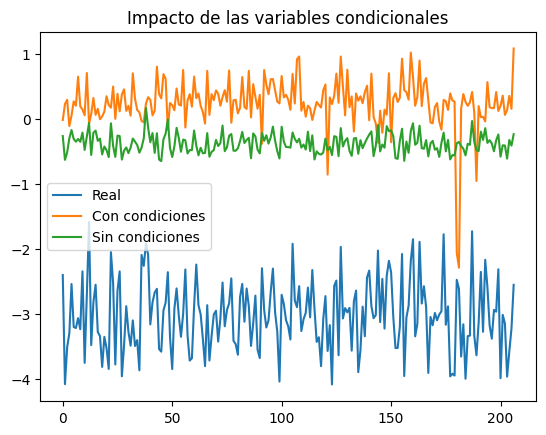

In [40]:
model.eval()
with torch.no_grad():
    x_sample = torch.tensor(x_test[100:101])
    c_normal = torch.tensor(c_test[100:101])
    c_fake = torch.zeros_like(c_normal)  # condiciones "neutrales"

    recon_normal = model(x_sample, c_normal)[0]
    recon_fake = model(x_sample, c_fake)[0]

    plt.plot(x_sample.numpy().flatten(), label="Real")
    plt.plot(recon_normal.numpy().flatten(), label="Con condiciones")
    plt.plot(recon_fake.numpy().flatten(), label="Sin condiciones")
    plt.legend()
    plt.title("Impacto de las variables condicionales")
    plt.show()


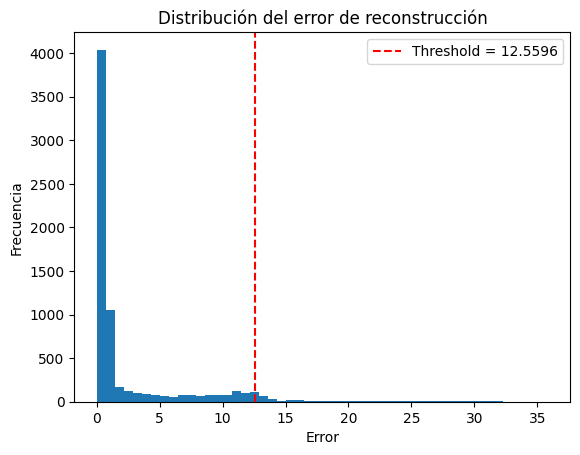

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist(reconstruction_errors, bins=50)
# plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
# plt.title("Distribución del error de reconstrucción")
# plt.xlabel("Error")
# plt.ylabel("Frecuencia")
# plt.legend()
# plt.show()


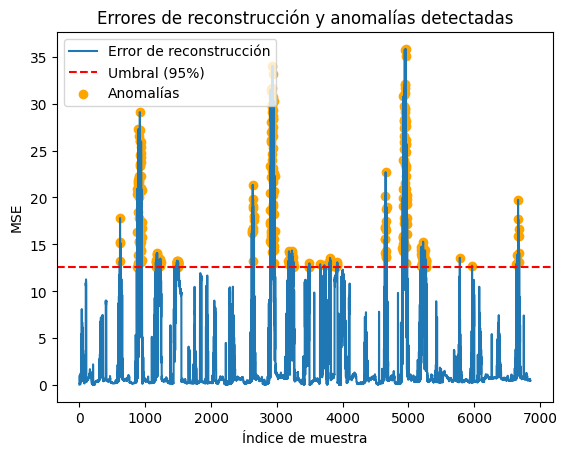

In [ ]:
# plt.plot(reconstruction_errors, label='Error de reconstrucción')
# plt.axhline(threshold, color='red', linestyle='--', label='Umbral (95%)')
# plt.scatter(np.where(anomalies)[0], np.array(reconstruction_errors)[anomalies], color='orange', label='Anomalías')
# plt.legend()
# plt.title("Errores de reconstrucción y anomalías detectadas")
# plt.xlabel("Índice de muestra")
# plt.ylabel("MSE")
# plt.show()


#### Sliding Windows

Sliding windows allow us to structure the time series data as sequences of fixed length, suitable for feeding into our VAE model.

The window size of 12 means each sample contains 12 consecutive timesteps (i.e., one hour of data).


In [10]:
def create_sliding_windows(data, window_size):
    X = []
    # for i in range(len(data) - window_size):
    #     X.append(data[i:i+window_size])
    i: int = 0
    while i < 34272:
        X.append(data[i:i+window_size])
        i= i + 12
    return np.array(X)

window_size = 12  # 12 pasos = 1 hora
X = create_sliding_windows(data_normalized, window_size)  # shape: (34260, 12, 207)
# 12 = rows
# 34260 =  
# 
print(X.shape)


(2856, 12, 207)
